In [1]:
import madmom
import aubio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import mir_eval
import time


In [2]:
# Určění tempa a dob skladby pomocí knihovny Librosa
def Beat_tracking_librosa(uploaded_file_name):
    y, sr = librosa.load(uploaded_file_name)
    tempo_librosa, beats_librosa = librosa.beat.beat_track(y=y, sr=sr)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    times = librosa.times_like(onset_env, sr=sr, hop_length=512)
    beats_librosa = times[beats_librosa]
    return beats_librosa

In [3]:
# Určení tempa a dob sklabdy pomocí knihovný Madmom
def Beat_tracking_madmom(uploaded_file_name):
    act = madmom.features.beats.RNNBeatProcessor()(uploaded_file_name)

    proc_beats = madmom.features.beats.BeatTrackingProcessor(fps =100)
    #proc_tempo = madmom.features.tempo.TempoEstimationProcessor(fps=100)
    beats_madmom = proc_beats(act)
    #tempo_madmom = proc_tempo(act)
    return beats_madmom


In [4]:
# Určení tempa a dob sklabdy pomocí knihovný Aubio
def Beat_tracking_aubio(filename):
    win_s = 512                 # velikost okna (vzorky)
    hop_s = win_s // 2          # velikost skoku (vzorky)
    samplerate = 0              

    s = aubio.source(filename, samplerate, hop_s)
    samplerate = s.samplerate

    tempo = aubio.tempo("default", win_s, hop_s, samplerate)

    beats = []
    while True:
        samples, read = s()
        is_beat = tempo(samples)
        if is_beat:
            this_beat = tempo.get_last_s()
            beats.append(this_beat)
        if read < hop_s: break

    beats = np.array(beats)
    # tempo_aubio = len(beats) / (beats[-1] - beats[0]) * 60 # Výpočet tempa

    return beats


In [5]:
def Print_graphs(uploaded_file_name, beats_librosa, beats_madmom,beats_aubio, beats_reference):
    # Vykreslení výsledků pro v čase xmin_time až xmax_time
    hop_length = 512
    xmin_time = 55 # Čas skladby, oa kterého se vykreslí grafy.
    xmax_time = 70 # Čas skladby, do kterého se vykreslí grafy.
    fig, ax = plt.subplots(5,1, figsize=(20,10))

    y, sr = librosa.load(uploaded_file_name)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)

    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)

    M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                            y_axis='mel', x_axis='time', hop_length=hop_length,
                            ax=ax[0])
    ax[0].label_outer()
    ax[0].set(title='Mel spectrogram')
    ax[0].set_xlim(xmin=xmin_time, xmax=xmax_time)

    ax[1].plot(times, librosa.util.normalize(onset_env),
            label='Onset strength')
    ax[1].vlines(beats_reference, 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats_reference')
    ax[1].legend()
    ax[1].set_xlabel("Time (s)")
    ax[1].set_xlim(xmin=xmin_time, xmax=xmax_time)

    ax[2].plot(times, librosa.util.normalize(onset_env),
            label='Onset strength')
    ax[2].vlines(beats_librosa, 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats_librosa')
    ax[2].legend()
    ax[2].set_xlabel("Time (s)")
    ax[2].set_xlim(xmin=xmin_time, xmax=xmax_time)

    ax[3].plot(times, librosa.util.normalize(onset_env),
            label='Onset strength')
    ax[3].vlines(beats_madmom, 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats_madmom')
    ax[3].legend()
    ax[3].set_xlabel("Time (s)")
    ax[3].set_xlim(xmin=xmin_time, xmax=xmax_time)

    ax[4].plot(times, librosa.util.normalize(onset_env),
            label='Onset strength')
    ax[4].vlines(beats_aubio, 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats_aubio')
    ax[4].legend()
    ax[4].set_xlabel("Time (s)")
    ax[4].set_xlim(xmin=xmin_time, xmax=xmax_time)

In [6]:
def Print_cemgil_score(beats_librosa, beats_madmom, beats_aubio, beats_reference):
    r_beats = mir_eval.beat.trim_beats(beats_reference)
    l_beats = mir_eval.beat.trim_beats(beats_librosa)
    m_beats = mir_eval.beat.trim_beats(beats_madmom)
    a_beats = mir_eval.beat.trim_beats(beats_aubio)

    cemgil_score_librosa, _ = mir_eval.beat.cemgil(r_beats, l_beats)
    cemgil_score_madmom, _ = mir_eval.beat.cemgil(r_beats, m_beats)
    cemgil_score_aubio, _ =mir_eval.beat.cemgil(r_beats, a_beats)

    print("Cemgil skóré Librosa: ",f"{cemgil_score_librosa: .4f}")
    print("Cemgil skóré Madmom: ",f"{cemgil_score_madmom: .4f}")
    print("Cemgil skóré Aubio: ",f"{cemgil_score_aubio: .4f}")


In [7]:
def Beat_tracking(uploaded_file_name, beats_reference):
    start_time = time.time()
    beats_librosa = Beat_tracking_librosa(uploaded_file_name)
    time_librosa = time.time() - start_time

    start_time = time.time()
    beats_madmom = Beat_tracking_madmom(uploaded_file_name)
    time_madmom = time.time() - start_time

    start_time = time.time()
    beats_aubio = Beat_tracking_aubio(uploaded_file_name)
    time_aubio = time.time() - start_time

    print("Čas trvání výpočtu Librosa:",f"{time_librosa: .4f}","s")
    print("Čas trvání výpočtu Madmom:",f"{time_madmom: .4f}","s")
    print("Čas trvání výpočtu Aubio:",f"{time_aubio: .4f}","s")

    Print_graphs(uploaded_file_name, beats_librosa, beats_madmom, beats_aubio, beats_reference)
    Print_cemgil_score(beats_librosa, beats_madmom, beats_aubio, beats_reference)


c:\Users\Zekon\AppData\Local\Programs\Python\Python311\Lib\site-packages\madmom\features\tempo.py:724: UserWarning: Usage of `method` is deprecated as of version 0.17. Please pass a dedicated `TempoHistogramProcessor` instance as `histogram_processor`.Functionality will be removed in version 0.19.
  warnings.warn(


Čas trvání výpočtu Librosa:  1.9064 s
Čas trvání výpočtu Madmom:  29.5911 s
Čas trvání výpočtu Aubio:  0.3595 s
Cemgil skóré Librosa:   0.3033
Cemgil skóré Madmom:   0.2782
Cemgil skóré Aubio:   0.2554


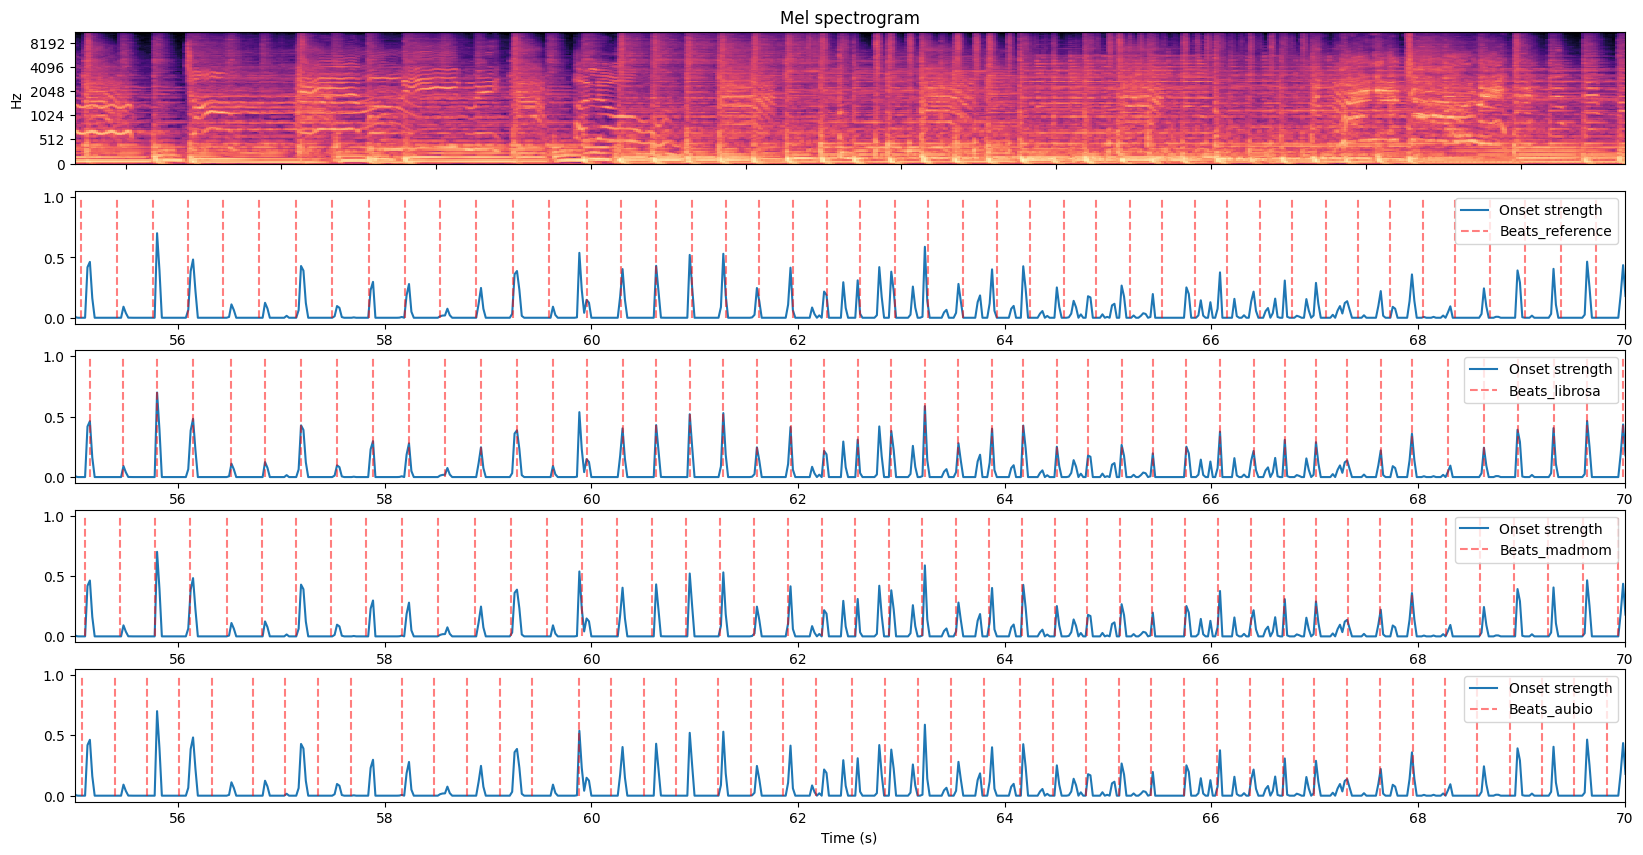

In [8]:
# Uložení cesty ke skladbě načtení vzorků a vzorkovací frekvence
uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/04.-Oh! Darling.wav"
beats_reference = np.loadtxt("Referencni_skladby/The Beatles Annotations/beat/The Beatles/11_-_Abbey_Road/04_-_Oh!_Darling.txt")
beats_reference = beats_reference[:,0]
Beat_tracking(uploaded_file_name, beats_reference)


Čas trvání výpočtu Librosa:  1.2335 s
Čas trvání výpočtu Madmom:  28.1969 s
Čas trvání výpočtu Aubio:  0.4380 s
Cemgil skóré Librosa:   0.1622
Cemgil skóré Madmom:   0.1344
Cemgil skóré Aubio:   0.1851


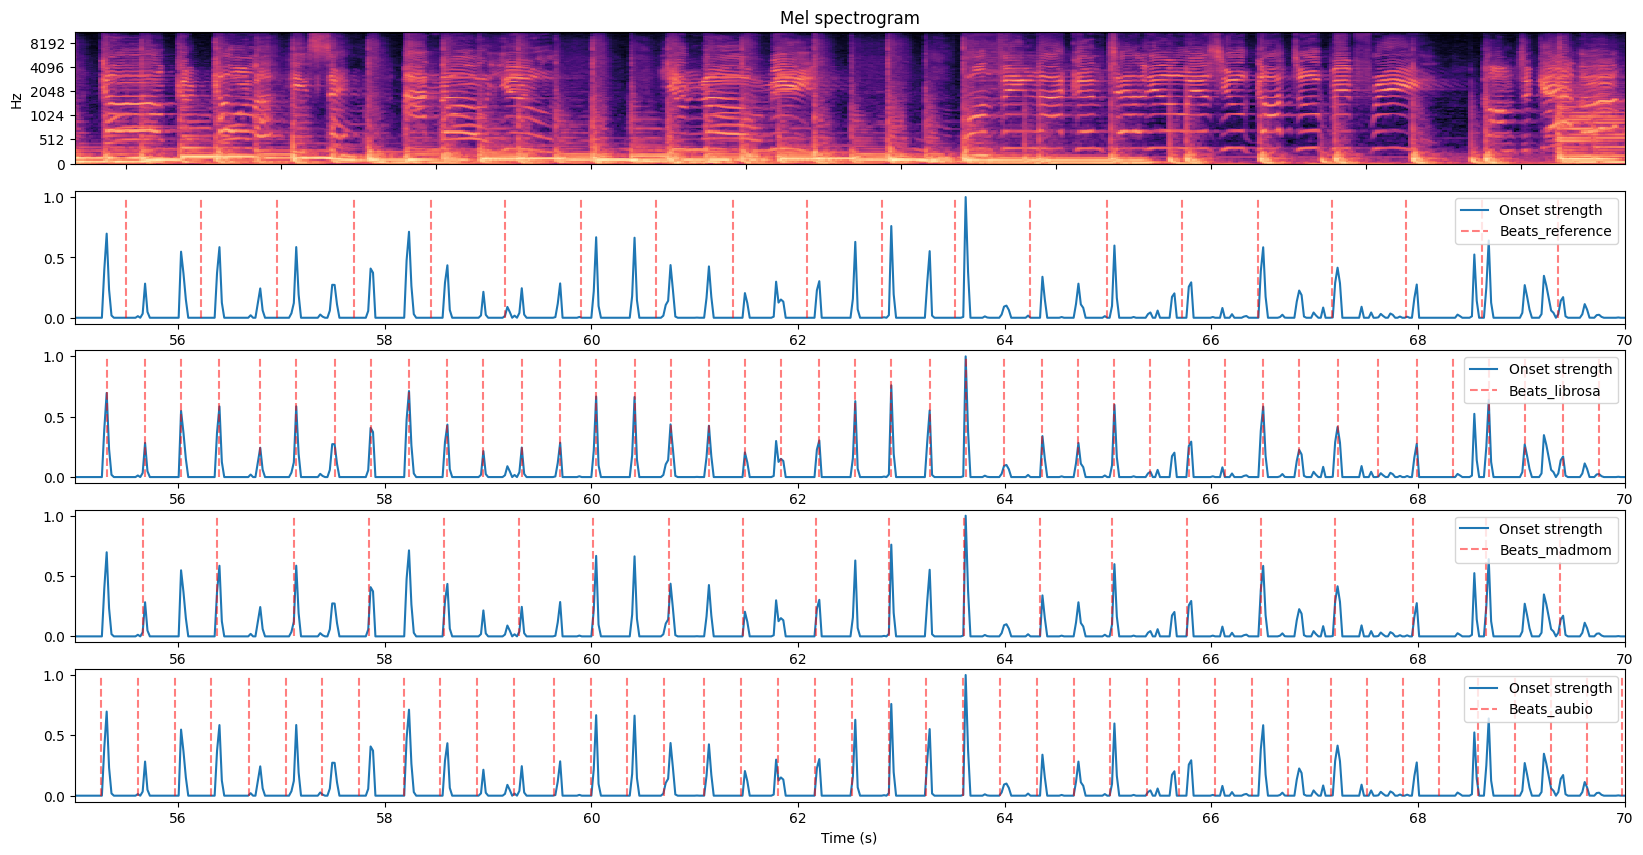

In [9]:
# Uložení cesty ke skladbě načtení vzorků a vzorkovací frekvence
uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/01.-Come Together.wav"
beats_reference = np.loadtxt("Referencni_skladby/The Beatles Annotations/beat/The Beatles/11_-_Abbey_Road/01_-_Come_Together.txt")
beats_reference = beats_reference[:,0]
Beat_tracking(uploaded_file_name, beats_reference)

Čas trvání výpočtu Librosa:  0.9003 s
Čas trvání výpočtu Madmom:  21.4670 s
Čas trvání výpočtu Aubio:  0.3230 s
Cemgil skóré Librosa:   0.2177
Cemgil skóré Madmom:   0.2128
Cemgil skóré Aubio:   0.2007


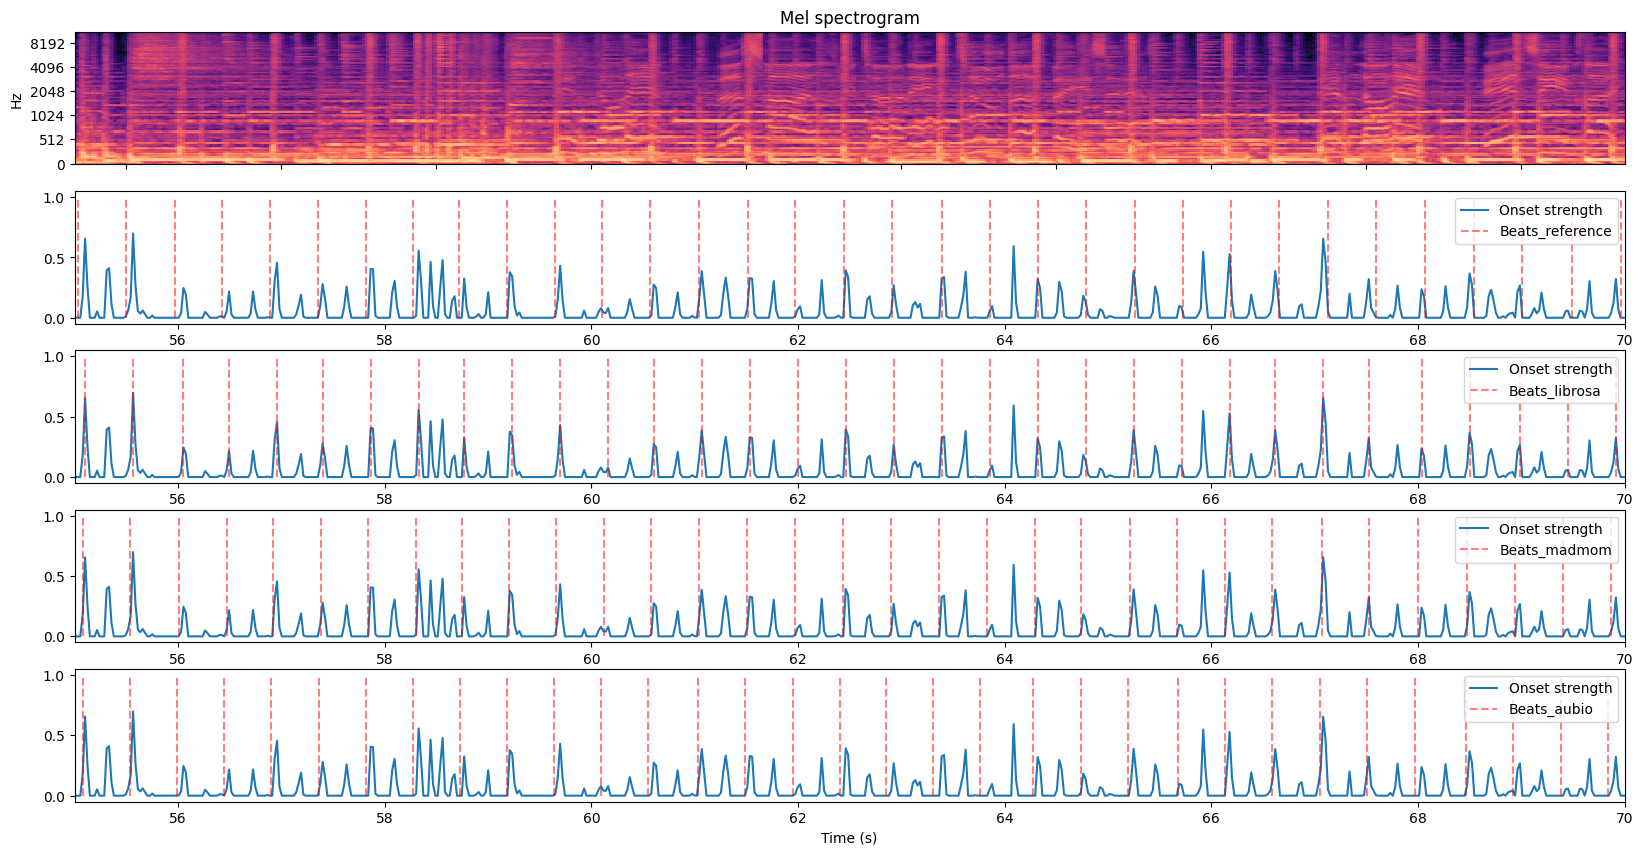

In [10]:
# Uložení cesty ke skladbě načtení vzorků a vzorkovací frekvence
uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/07.-Here Comes The Sun.wav"
beats_reference = np.loadtxt("Referencni_skladby/The Beatles Annotations/beat/The Beatles/11_-_Abbey_Road/07_-_Here_Comes_The_Sun.txt")
beats_reference = beats_reference[:,0]
Beat_tracking(uploaded_file_name, beats_reference)

Čas trvání výpočtu Librosa:  0.7550 s
Čas trvání výpočtu Madmom:  17.9019 s
Čas trvání výpočtu Aubio:  0.2640 s
Cemgil skóré Librosa:   0.1846
Cemgil skóré Madmom:   0.2111
Cemgil skóré Aubio:   0.1971


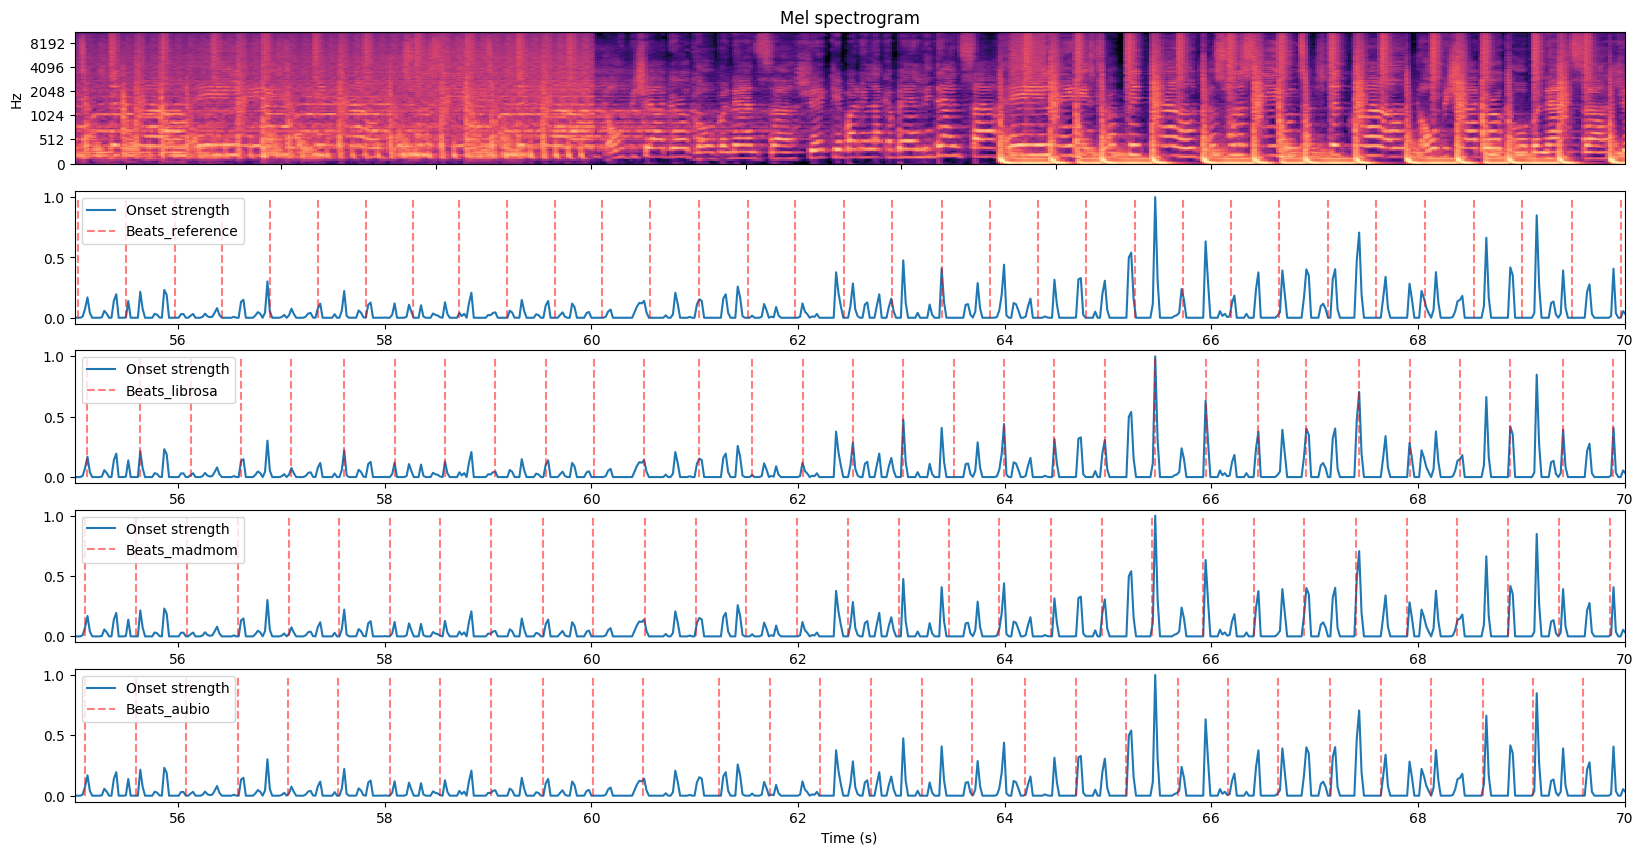

In [11]:
uploaded_file_name = "Referencni_skladby/Imanbek & BYOR - Belly Dancer (Official Music Video).wav"
Beat_tracking(uploaded_file_name, beats_reference)